In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from Conv_tnn import DoG
mnist = fetch_mldata('MNIST original')
N, _ = mnist.data.shape

# Reshape the data to be square
mnist.square_data = mnist.data.reshape(N,28,28)

In [2]:
layer = DoG(layer_name='DoG', threshold=None)

In [3]:
result = layer(mnist.square_data[0])

In [4]:
result.shape
result.max()

7.0

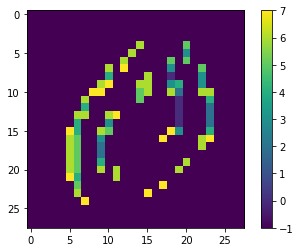

In [6]:
plt.imshow(result[:,:,1])
plt.colorbar()
plt.show()

In [61]:
A = np.random.randint(low=1, high=7, size=(4,3,3))
for i in range(A.shape[1]):
    for j in range(A.shape[2]):
        if (i%2 != j%2):
            A[:, i, j] = 0

In [62]:
#A[:, int(A.shape[1]/2), int(A.shape[1]/2)] = 0
A

array([[[4, 0, 4],
        [0, 5, 0],
        [2, 0, 4]],

       [[3, 0, 3],
        [0, 1, 0],
        [6, 0, 6]],

       [[4, 0, 1],
        [0, 5, 0],
        [5, 0, 6]],

       [[2, 0, 1],
        [0, 1, 0],
        [3, 0, 6]]])

In [74]:
a = np.zeros((3,3,6))
a[0,0,:].shape

(6,)

In [65]:
a[[1,3,0]] = 1
a/a.sum()

array([0.33333333, 0.33333333, 0.        , 0.33333333, 0.        ,
       0.        ])

In [73]:
np.random.choice(6, 1, p=a/a.sum())[0] 

0

In [401]:
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_mldata
MAX_TIME = 8

class Layer():
    def __init__(self, layer_name, threshold):
        self.layer_name = layer_name
        self.threshold = threshold

    def __call__(self, x):
        return self.forward(x)

    def reset(self):
        # Reset the network, clearing out any accumulator variables, etc
        pass

    def forward(self, x):
        """
        This function will control the different processing steps for a
        single image

        """
        pass

class DoG(Layer):
    def __init__(self, layer_name, threshold, mode):
        super(DoG, self).__init__(layer_name, threshold)
        self.on_kernel = None 
        self.off_kernel = None 
        self.mode = mode
        self._build_kernel()

    def _build_kernel(self):
        self.on_kernel = np.array([[-1/8,-1/8,-1/8],[-1/8,1,-1/8],[-1/8,-1/8,-1/8]])
        self.off_kernel = np.array([[1/8,1/8,1/8],[1/8,-1,1/8],[1/8,1/8,1/8]])
        
    def _conv(self, x):
        return np.array([np.matmul(x, self.on_kernel).sum(), np.matmul(x, self.off_kernel).sum()]).reshape(1, 2)

    def _generate_spike(self, x):
        spiketimes = np.zeros(x.shape)        
        # Make large numbers represent earlier spikes (largest value maps to spike
        # at time 0), and vice versa
        spiketimes = np.full(x.shape, np.amax(x)) - x

        # Negative values map to no spikes
        spiketimes[x < 0] = -1
        spiketimes[spiketimes > 7] = -1
        spiketimes = np.round(spiketimes)
        # We set 0 as no spike and the minimum spiketime starts from 1 and ends at 8
        # This is mainly for the simplicity 
        if self.mode == 'Full':
            return spiketimes+1
        elif self.mode == 'On':
            return spiketimes[:0]+1
        else:
            return spiketimes[1:]+1
        
    def forward(self, x, num_bits=3):
        a = []
        for i in range(2 ** num_bits):
            a += [i] * int(256/(2 ** num_bits))
        a = np.asarray(a)
        scaled_data = a[x]
        W, H = scaled_data.shape
        filtered_data = np.zeros((W, H, 2))
        padded_data = np.pad(scaled_data,
                            ((1, 1), (1, 1)),
                            'constant',
                            constant_values=0) #deal with the edge by padding around
        for i in range(1, padded_data.shape[0]-1):
            for j in range(1, padded_data.shape[1]-1):
                filtered_data[i-1, j-1, :] = self._conv(padded_data[i-1:i+2, j-1:j+2])

        return self._generate_spike(filtered_data)

class Conv(Layer):
    def __init__(self, layer_name, threshold, mode, size, stride, pad):
        super(Conv, self).__init__(layer_name, threshold)
        self.mode = mode
        self.stride = stride
        self.pad = pad
        self.size = size 
        self.threshold = threshold
        self.rf = self._rf_init()
        self.weights = np.random.randint(low=1, high=8, size=self.rf.shape) * self.rf
        self.rf = self.rf[0]

    def _rf_init(self):
        '''
            size should be Channel First. e.g: 4x3x3
            mode: 
            Full: all receptive filed
            Cornel: e.g.:   [1, 0, 1],
                            [0, 0, 0],
                            [1, 0, 1]]
            Center: e.g.:   [1, 0, 1],
                            [0, 1, 0],
                            [1, 0, 1]]

        '''
        kernel = np.ones(self.size)
        if self.mode == 'Full':
            return kernel 
        if self.mode == 'Corner':
            for i in range(kernel.shape[1]):
                for j in range(kernel.shape[2]):
                    if (i%2 != j%2):
                        kernel[:, i, j] = 0    
            kernel[:, int(kernel.shape[1]/2), int(kernel.shape[1]/2)] = 0   
            return kernel    
        if self.mode == 'Center':
            for i in range(kernel.shape[1]):
                for j in range(kernel.shape[2]):
                    if (i%2 != j%2):
                        kernel[:, i, j] = 0    
            return kernel   
    
    def _conv(self, window, weights, potentials=None):
        '''
        x: WxHxC input window
        weights: WxH  corresponding weights
        potentials: initial potentials
        '''
        if potentials is None:
            potentials = np.zeros(MAX_TIME)    
        x = np.transpose(window, (2,0,1)) # transpose to channel first 
        for channel in x:
            channel *= self.rf 
            for i in range(channel.shape[0]):
                for j in range(channel.shape[1]):
                    if channel[i][j]:
                        potentials[int(channel[i][j])-1:] += weights[i][j]
        diff = potentials > self.threshold
        if True in diff:
            return np.where(diff == True)[0][0] + 1
        else:
            return 0
        
    def forward(self, x):
        W, H, C = x.shape
        Wout = (int(W - self.size[1] + 2*self.pad) / self.stride) + 1
        Hout = (int(H - self.size[2] + 2*self.pad) / self.stride) + 1
        Cout = self.size[0]
        Wout, Hout, Cout = int(Wout), int(Hout), int(Cout)
        result = np.zeros((Wout, Hout, Cout))
        w = int(self.rf.shape[0]/2)
        h = int(self.rf.shape[1]/2)
        x = np.pad(x, ((self.pad, self.pad), (self.pad, self.pad), (0, 0)), 'constant', constant_values=0) #deal with the edge by padding around  
        for k in range(self.size[0]): # for each filter
            for i in range(w, x.shape[0]-w, self.stride):
                for j in range(h, x.shape[1]-h, self.stride):
                    window = x[i-w:i+w+1, j-h:j+h+1, :]
                    result[int((i-w)/self.stride), int((j-h)/self.stride), k] = self._conv(window.copy(), self.weights[k])
        return result


class LI(Layer):
    def __init__(self, layer_name):
        super(LI, self).__init__(layer_name, None)
        
    def forward(self, x):
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                if np.sum(x[i, j, :]):
                    a = x[i, j, :]
                    fire_id = np.random.choice(a.shape[0], 1, p=a/a.sum())[0]     
                    mask = np.zeros_like(a)  
                    mask[fire_id] += 1
                    x[i, j, :] *= mask
        return x

class MaxPool(Layer):
    def __init__(self, layer_name, size, stride):
        super(MaxPool, self).__init__(layer_name, None)
        self.size = size
        self.stride = stride

    def _pool(self, window):
        window = window.flatten()
        window = np.sort(window)
        for x in window:
            if x > 0:
                return x
        return 0

    def forward(self, x):
        W, H, C = x.shape
        Wout = (int(W - self.size) / self.stride) + 1
        Hout = (int(H - self.size) / self.stride) + 1
        Cout = C
        Wout, Hout, Cout = int(Wout), int(Hout), int(Cout)
        result = np.zeros((Wout, Hout, Cout)) #channel first
        print (result.shape)
        w = int(self.size/2)
        h = int(self.size/2)       
        for k in range(C): # for each filter
            for i in range(w, W-w, self.stride):
                for j in range(h, H-h, self.stride):
                    window = x[i-w:i+w+1, j-h:j+h+1, k]
                    result[int((i-w)/self.stride), int((j-h)/self.stride), k] = self._pool(window.copy())            
        return result           

In [411]:
mnist = fetch_mldata('MNIST original')
N, _ = mnist.data.shape

# Reshape the data to be square
mnist.square_data = mnist.data.reshape(N,28,28)
layer1 = DoG(layer_name='DoG', threshold=None, mode='Full')
layer2 = Conv(layer_name='conv1', threshold=19, mode='Full', size=(2,5,5), stride=1, pad=1)
layer3 = LI(layer_name='conv1_LI')
layer4 = MaxPool(layer_name='conv1_pool', size=3, stride=4)

In [420]:
def Model():
    layer = []
    layer.append(DoG(layer_name='DoG', threshold=None, mode='Full'))
    layer.append(Conv(layer_name='conv1', threshold=19, mode='Full', size=(7,5,5), stride=1, pad=1))
    layer.append(LI(layer_name='conv1_LI'))
    layer.append(MaxPool(layer_name='conv1_pool', size=3, stride=2))
    
    layer.append(Conv(layer_name='conv2', threshold=19, mode='Full', size=(16,3,3), stride=1, pad=1))
    layer.append(LI(layer_name='conv2_LI'))
    layer.append(MaxPool(layer_name='conv2_pool', size=3, stride=2))
    
    layer.append(Conv(layer_name='conv3', threshold=19, mode='Full', size=(32,3,3), stride=1, pad=1))
    
    model = {layer[i].layer_name:layer[i] for i in range(len(layer))}
    return model
        
    

In [421]:
model = Model()

In [424]:
model['conv1'].weights

array([[[7., 6., 4., 7., 5.],
        [1., 2., 4., 2., 5.],
        [2., 4., 7., 5., 3.],
        [1., 4., 6., 7., 6.],
        [7., 2., 4., 4., 4.]],

       [[5., 7., 2., 4., 7.],
        [3., 7., 4., 7., 4.],
        [7., 5., 3., 7., 5.],
        [7., 4., 6., 1., 3.],
        [3., 3., 4., 1., 4.]],

       [[6., 5., 4., 5., 3.],
        [1., 4., 6., 3., 7.],
        [5., 7., 1., 1., 5.],
        [6., 4., 4., 2., 3.],
        [1., 6., 2., 6., 3.]],

       [[5., 2., 4., 7., 6.],
        [4., 2., 7., 4., 5.],
        [3., 7., 4., 4., 1.],
        [2., 4., 3., 6., 4.],
        [4., 3., 3., 6., 5.]],

       [[1., 3., 6., 3., 6.],
        [7., 2., 5., 3., 4.],
        [1., 5., 2., 1., 1.],
        [2., 4., 6., 7., 2.],
        [6., 3., 5., 7., 3.]],

       [[3., 5., 1., 5., 4.],
        [4., 2., 6., 6., 5.],
        [7., 6., 7., 7., 4.],
        [1., 7., 1., 3., 6.],
        [4., 4., 7., 5., 6.]],

       [[1., 4., 2., 5., 7.],
        [2., 5., 2., 3., 7.],
        [3., 7., 1., 7., 4.]

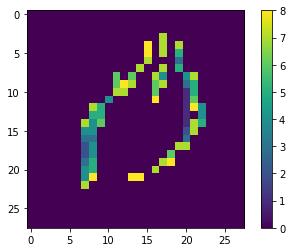

In [412]:
result = layer1(mnist.square_data[0])
plt.imshow(result[:,:,0])
plt.colorbar()
plt.show()

In [413]:
result2 = layer2(result)

In [414]:
result2.shape

(26, 26, 2)

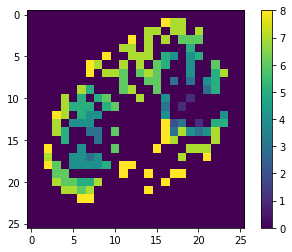

In [425]:
plt.imshow(result2[:,:,0])
plt.colorbar()
plt.show()

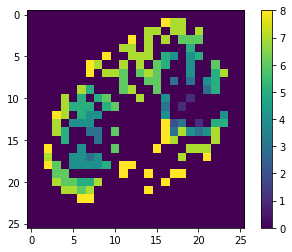

In [426]:
result3 = layer3(result2)
plt.imshow(result3[:,:,0])
plt.colorbar()
plt.show()

In [417]:
result4 = layer4(result3)

(6, 6, 2)


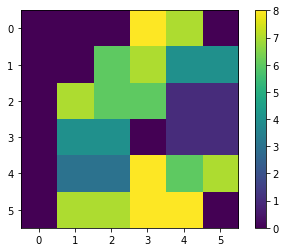

In [427]:
plt.imshow(result4[:,:,1])
plt.colorbar()
plt.show()